In [307]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

In [308]:
#导入数据
data1 = pd.read_excel('./cumcm2018c1.xlsx')
data2 = pd.read_csv('./cumcm2018c2.csv', encoding='UTF-8')
#合并会员表与销售表
data = pd.merge(data1,data2, on='kh')

In [309]:
data['dtime'] = pd.to_datetime(data['dtime'])#转化为日期格式数据

In [310]:
data = data[['kh','dtime','je','djh']]#字段提取
data.columns = ['会员卡号','付款时间','消费金额','单据号']

In [311]:
data = data.drop(data[data.消费金额 < 0].index)#将消费金额中不符合常理的数据剔除
data['消费金额'].describe().astype(int) 

count     501652
mean        1391
std         3422
min            0
25%          328
50%          702
75%         1587
max      1342515
Name: 消费金额, dtype: int32

In [312]:
#R值(最近一次购物距今来多少天)字段构建
date = data.groupby('会员卡号')['付款时间'].max().reset_index()
date.columns = ['会员卡号','最近一次付款时间']
date['R'] = (pd.to_datetime('2018-1-4') - date['最近一次付款时间']).dt.days
RFM = date[['会员卡号','R']]

In [313]:
#F值（购买商品的频率）字段构建
f = data.groupby('会员卡号')['单据号'].count().reset_index()
f.columns = ['会员卡号','F']
RFM = pd.merge(RFM,f,on='会员卡号' )

In [315]:
#M值(消费总金额)字段构建
sum = data.groupby('会员卡号')['消费金额'].sum().reset_index()
sum.columns = ['会员卡号','消费总金额']
RFM = pd.merge(RFM,sum,on='会员卡号' )
RFM['M'] = RFM['消费总金额']
RFM = RFM[['会员卡号','R','F','M']]

In [316]:
#标准化处理
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(RFM[['R','F','M']])
RFM_normal = sc.transform(RFM[['R','F','M']])

In [317]:
#k值的选择评价
from sklearn.metrics import calinski_harabasz_score
for i in range(3,6):
    kmeans = KMeans(n_clusters=i,random_state=1).fit(RFM[['R','F','M']])
    score = calinski_harabasz_score(RFM[['R','F','M']],kmeans.labels_)
    print('RFM数据集聚%d类calinski_harabasz指数为：%f'%(i,score))R

RFM数据集聚3类calinski_harabasz指数为：54665.678927
RFM数据集聚4类calinski_harabasz指数为：64292.901441
RFM数据集聚5类calinski_harabasz指数为：79291.438367


In [318]:
#k-means聚类分析
from sklearn.cluster import KMeans
model = KMeans(n_clusters=5, random_state=1)
model.fit(RFM_normal)
label = fit_model.labels_
RFM['K-means_label'] = label

In [319]:
#查看聚类中心
print('聚类中心\n',model.cluster_centers_) 
#查看各样本对应的类别数目
print('类别\n',pd.Series(model.labels_).value_counts())

聚类中心
 [[-5.20352207e-01 -1.06629142e-01 -1.12909602e-01]
 [ 1.42145579e+00 -2.30286296e-01 -2.11751466e-01]
 [-9.06169845e-01  2.28662024e+00  2.14255204e+00]
 [-1.06465209e+00  8.74382973e+00  1.05374682e+01]
 [-1.10301026e+00  1.09383452e+02  7.27141124e+01]]
类别
 0    31900
1    13161
2     2135
3      167
4        1
dtype: int64


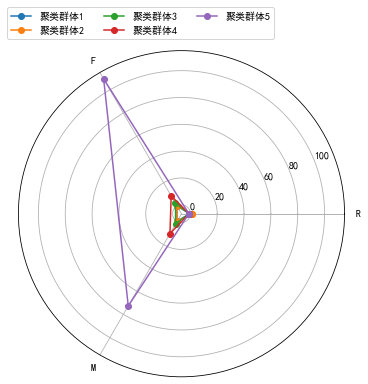

In [320]:
# 绘制雷达图
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

angles = np.linspace(0,2*np.pi,3,endpoint=False) # 将圆根据标签的个数等比分
angles = np.concatenate((angles,[angles[0]])) # 闭合
centers = model.cluster_centers_  # 获取聚类中心数据
plot_data = np.concatenate((centers,centers[:,[0]]),axis=1)
label = ['R','F','M'] # 设置标签
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111,polar = True)
for i in range(len(plot_data)):
    ax.plot(angles, plot_data[i], 'o-', label='聚类群体'+str(i+1))
ax.set_thetagrids(angles*180/np.pi, label)
plt.legend(bbox_to_anchor=(0.8, 1.15),ncol=3) # 设置图例的位置
plt.savefig('./K-means聚类雷达图.png')    
plt.show()

In [321]:
RFM.groupby(['K-means_label']).agg({'R':'mean','F':'mean','M':['mean','count']})R

R           F              M       
                     mean        mean           mean  count
K-means_label                                              
0              878.857827    4.230511    4839.327256  12520
1              216.199802    6.136547    7309.934751  29294
2               28.218947  164.680000  267513.126126    475
3              346.045685   10.123858   48807.810376    985
4               76.628117   44.187531   60676.522213   4090

,聚类类别,数目
0,0,12520
1,1,29294
2,2,475
3,3,985
4,4,4090


,K-means_label,会员卡号,聚类类别,数目
0,0,12520,1,000186fa
1,1,29294,1,000234ad
2,2,475,1,000339f1
3,3,985,1,0004bad2
4,4,4090,1,000539ab
